# Social Media Sentiment Analysis

## Problem Statement

Conduct a comprehensive analysis of social media data to uncover insights into user sentiment distribution, engagement patterns, and content preferences across different platforms and geographical locations.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re

from scipy import stats

## Dataset

In [2]:
data = pd.read_csv("dataset.csv")
data.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

data.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


### Data Dictionary of this dataset


* Text: The text content of the social media post.
* Sentiment: Categorized sentiment of the post (e.g., Positive, Negative, Neutral).
* Timestamp: The date and time when the post was made.
* User: Identifier or username of the post's author.
* Platform: The social media platform where the post was made (e.g., Twitter, Facebook).
* Hashtags: Hashtags used in the post, indicating topics or themes.
* Retweets: The number of times the post has been retweeted or shared.
* Likes: The number of likes the post has received.
* Country: The country from which the post was made.
* Year: The year when the post was made.
* Month: The month when the post was made.
* Day: The day of the month when the post was made.
* Hour: The hour of the day when the post was made, using a 24-hour clock.

## Preprocessing Data

### 1. Checking and Handling Missing Values

In [3]:
data.shape

(732, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


- data.info() suggest `no missing values`.
- Let's check for data cleaning

### 2. Removing Leading and Trailing Spaces

In [5]:
data["Platform"].unique()

array([' Twitter  ', ' Instagram ', ' Facebook ', ' Twitter '],
      dtype=object)

In [6]:
data["Country"].unique()[: 10]

array([' USA      ', ' Canada   ', ' USA        ', ' UK       ',
       ' Australia ', ' India    ', ' USA    ', 'USA', ' Canada    ',
       ' USA       '], dtype=object)

In [7]:
data["Hashtags"].unique()[:5]

array([' #Nature #Park                            ',
       ' #Traffic #Morning                        ',
       ' #Fitness #Workout                        ',
       ' #Travel #Adventure                       ',
       ' #Cooking #Food                           '], dtype=object)

*Removing Leading and Trailing whitespaces from textual data.*

In [8]:
for column in data.columns:
    if data[column].dtype == object:
        data[column] = data[column].str.strip()

### 3. Dealing with duplicates

In [9]:
data.duplicated().sum()

22

In [10]:
data.drop_duplicates(keep='first', inplace=True)

In [11]:
data.shape

(710, 13)

### 4. Optimising memory for numerical column dtypes

In [12]:
print(f"meory usage before datatype optimisation: {data.memory_usage().sum()}")

meory usage before datatype optimisation: 79520


In [13]:
for column in data.columns:
    if np.issubdtype(data[column].dtype, np.number):
        print(f"{column} ==> Min: {min(data[column])}, Max: {max(data[column])}")


Retweets ==> Min: 5.0, Max: 40.0
Likes ==> Min: 10.0, Max: 80.0
Year ==> Min: 2010, Max: 2023
Month ==> Min: 1, Max: 12
Day ==> Min: 1, Max: 31
Hour ==> Min: 0, Max: 23


- Converting dtypes of `Retweets, Likes, Month, Day and Hour` columns to **`np.uint8`** dtype.
- Converting dtypes of `Year` to **`np.uint16`** dtype.

In [14]:
data["Retweets"] = data["Retweets"].astype(np.uint8)
data["Likes"] = data["Likes"].astype(np.uint8)
data["Month"] = data["Month"].astype(np.uint8)
data["Day"] = data["Day"].astype(np.uint8)
data["Hour"] = data["Hour"].astype(np.uint8)

data["Year"] = data["Year"].astype(np.uint16)

In [15]:
for column in data.columns:
    if np.issubdtype(data[column].dtype, np.number):
        print(f"{column} ==> Min: {min(data[column])}, Max: {max(data[column])}")


Retweets ==> Min: 5, Max: 40
Likes ==> Min: 10, Max: 80
Year ==> Min: 2010, Max: 2023
Month ==> Min: 1, Max: 12
Day ==> Min: 1, Max: 31
Hour ==> Min: 0, Max: 23


In [16]:
print(f"meory usage after datatype optimisation: {data.memory_usage().sum()}")

meory usage after datatype optimisation: 50410


- Earlier memory usage is `80.2 kb`
- After dtype optimisation memory usage is `46.6 kb`

### 5. Converting `Timestamp` to pandas datetime format.

In [17]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [18]:
data['Timestamp'].dt.day_name()

0        Sunday
1        Sunday
2        Sunday
3        Sunday
4        Sunday
         ...   
727      Friday
728      Friday
729      Friday
730    Saturday
731      Sunday
Name: Timestamp, Length: 710, dtype: object

### 6. Handling Unnested data-

- Hashtags and Sentiments contains nested data.
- To unnest them I will separate the hashtags and sentiments into different dataframes.
- Now to hold the relationship between separated hashtags, sentiments and the post, I will also create an unique id column.

#### Creating id column

In [19]:
total_records = data.shape[0]
total_records

710

In [20]:
data["id"] = np.arange(1, total_records +1, dtype=np.uint16)
data.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,id
0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,1
1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,2
2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,3
3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,4
4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,5


#### a) Handling Nested Hashtags

In [21]:
data_hashtags = data["Hashtags"].apply(lambda s: str(s).split()).tolist()
data_hashtags = pd.DataFrame(data_hashtags, index = data["id"])

# pivot the dataframe
data_hashtags = data_hashtags.stack()

# convert it back to dataframe after reseting indices
data_hashtags = pd.DataFrame(data_hashtags.reset_index())

# dropping 'level_1' and renaming other column
data_hashtags.rename(columns={0: "Hashtags"}, inplace=True)
data_hashtags.drop(columns=["level_1"], inplace=True)

data_hashtags.head()

,id,Hashtags
0,1,#Nature
1,1,#Park
2,2,#Traffic
3,2,#Morning
4,3,#Fitness


#### b) Handling Nested Sentiments

In [22]:
def sentiment_splitter(s):
    if " " in s:
        if "'s " in s:
            s = s.replace("'s ", " ")
        return s.split(" ")
    else:
        return re.findall(r'[A-Z][a-z]*', s)

In [23]:
data_sentiments = data["Sentiment"].apply(sentiment_splitter).tolist()

data_sentiments = pd.DataFrame(data_sentiments, index = data["id"])

# pivot the dataframe
data_sentiments = data_sentiments.stack()

# convert it back to dataframe after reseting indices
data_sentiments = pd.DataFrame(data_sentiments.reset_index())

# dropping 'level_1' and renaming other column
data_sentiments.rename(columns={0: "Sentiment"}, inplace=True)
data_sentiments.drop(columns=["level_1"], inplace=True)

data_sentiments.head()

,id,Sentiment
0,1,Positive
1,2,Negative
2,3,Positive
3,4,Positive
4,5,Neutral


#### Dropping Hashtags, Timestamp, Sentiment columns from original dataframe

In [24]:
data.drop(columns=["Sentiment", "Hashtags"], inplace=True)
data.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day,Hour,id
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15,30,USA,2023,1,15,12,1
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5,10,Canada,2023,1,15,8,2
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20,40,USA,2023,1,15,15,3
3,Excited about the upcoming weekend getaway!,2023-01-15 18:20:00,AdventureX,Facebook,8,15,UK,2023,1,15,18,4
4,Trying out a new recipe for dinner tonight.,2023-01-15 19:55:00,ChefCook,Instagram,12,25,Australia,2023,1,15,19,5


## Performing EDA

### Feature Engineering: Creating new features.

1. **`TextLength`**: Column for length of Post

In [25]:
data["TextLength"] = data["Text"].apply(lambda s: len(s)).astype(np.uint8)

2. **`HourSegment`**: Group hours in **Morning, Noon, Evening, Night and Late-Night** segments.

In [26]:
def getHourSegment(n):
    if 1 <= n and n <= 5:
        return "Late-Night"
    elif n <= 11:
        return "Morning"
    elif n <= 15:
        return "Noon"
    elif n <= 20:
        return "Evening"
    else:
        return "Night"

In [27]:
data["HourSegment"] = data["Hour"].apply(getHourSegment)

3. **`DaySegment`**: Group days in **Month-Start, Month-Mid and Month-End** segments.

In [28]:
def getDaySegment(n):
    if 1 <= n and n <= 10:
        return "Month-Start"
    elif n <= 20:
        return "Month-Mid"
    else:
        return "Month-End"

In [29]:
data["DaySegment"] = data["Day"].apply(getDaySegment)


4. **`Quarter`**: Group Month in Quarters

In [30]:
def getQuarter(n):
    if 1 <= n and n <= 3:
        return "Quarter-1"
    elif n <= 6:
        return "Quarter-2"
    elif n <= 9:
        return "Quarter-3"
    else:
        return "Quarter-4"

In [31]:
data["Quarter"] = data["Month"].apply(getQuarter)


5. **`DayName`**: Sunday, Monday, ..., Saturday

In [32]:
data['DayName'] = data['Timestamp'].dt.day_name()

In [33]:
data.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day,Hour,id,TextLength,HourSegment,DaySegment,Quarter,DayName
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15,30,USA,2023,1,15,12,1,37,Noon,Month-Mid,Quarter-1,Sunday
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5,10,Canada,2023,1,15,8,2,34,Morning,Month-Mid,Quarter-1,Sunday
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20,40,USA,2023,1,15,15,3,35,Noon,Month-Mid,Quarter-1,Sunday
3,Excited about the upcoming weekend getaway!,2023-01-15 18:20:00,AdventureX,Facebook,8,15,UK,2023,1,15,18,4,43,Evening,Month-Mid,Quarter-1,Sunday
4,Trying out a new recipe for dinner tonight.,2023-01-15 19:55:00,ChefCook,Instagram,12,25,Australia,2023,1,15,19,5,43,Evening,Month-Mid,Quarter-1,Sunday


### Univariate Analysis

#### Distribution of TextLength, Retweets and Likes

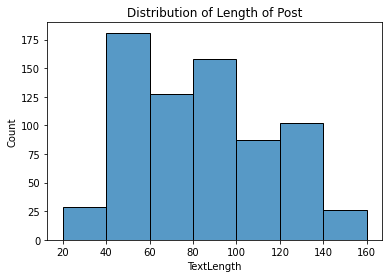

In [34]:
sns.histplot(data=data, x="TextLength", binwidth=20, binrange=(20, 160))
plt.title("Distribution of Length of Post")

plt.show()

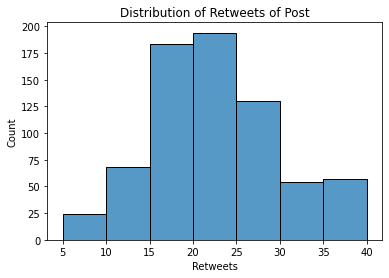

In [35]:
sns.histplot(data=data, x="Retweets", binwidth=5)
plt.title("Distribution of Retweets of Post")

plt.show()

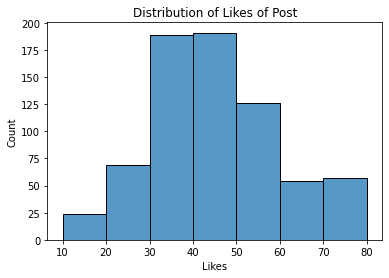

In [36]:
sns.histplot(data=data, x="Likes", binwidth=10)
plt.title("Distribution of Likes of Post")

plt.show()

Insights:-

1. Majority of the Posts' Length lies in the range: `40-140`
2. Majority of the Posts gets `15-30` Retweets
3. Majority of the Posts `30-60` Likes


Note:-
- *It also seems like a post usually gets twice number of likes compared to retweets.*
- I will test above statement later.

#### Boxplot for checking outliers and calculating pct of outliers

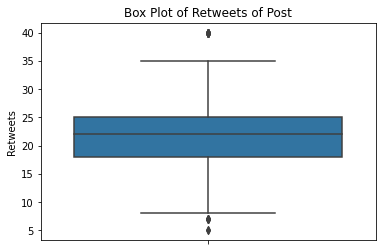

In [37]:
sns.boxplot(data=data, y="Retweets")
plt.title("Box Plot of Retweets of Post")

plt.show()

In [38]:
p25 = np.percentile(data["Retweets"], 25)
p75 = np.percentile(data["Retweets"], 75)

iqr = p75 - p25
iqr

7.0

In [39]:
outliers = data[(data["Retweets"] > (p75 + 1.5*iqr)) | (data["Retweets"] < (p25 - 1.5*iqr))].shape[0]
outliers

25

In [40]:
total = data.shape[0]
outliers_pct = outliers * 100 / total

outliers_pct

3.5211267605633805

Insights:-
1. `25` retweets numbers or `3.52%` data-points are outliers.

#### Plots related to Trends of Posting

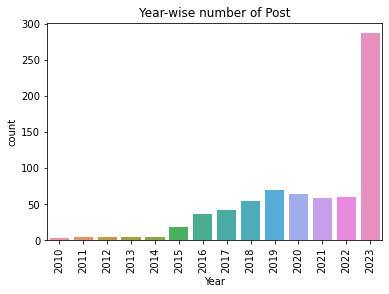

In [41]:
sns.countplot(data=data, x = "Year")
plt.title("Year-wise number of Post")
plt.xticks(rotation = 90)

plt.show()

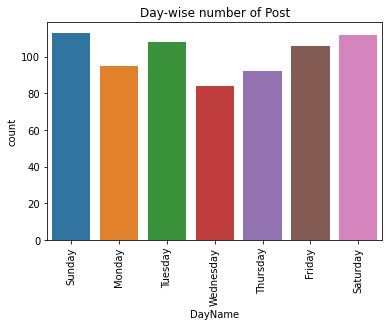

In [42]:
sns.countplot(data=data, x = "DayName")
plt.title("Day-wise number of Post")
plt.xticks(rotation = 90)

plt.show()

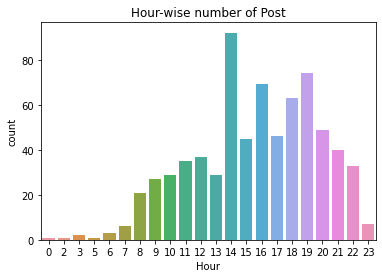

In [43]:
sns.countplot(data=data, x = "Hour")
plt.title("Hour-wise number of Post")

plt.show()

Insights:-
1. There is a sudden-rise in number of posts in `2023`.
2. Frequency of posts between `14-21` hour time-period is comparatively very high.
3. Weekends i.e., `Saturday and Sunday` are the days of origin of maximum posts, followed by Tuesday and Friday

#### Categorical Type Univariate Plots

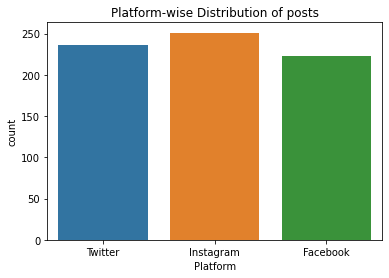

In [44]:
sns.countplot(data=data, x = "Platform")
plt.title("Platform-wise Distribution of posts")

plt.show()

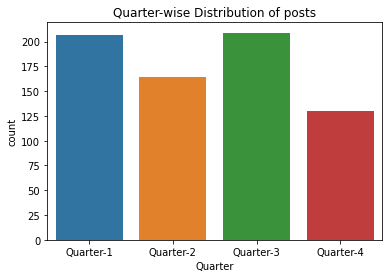

In [45]:
sns.countplot(data=data, x = "Quarter")
plt.title("Quarter-wise Distribution of posts")

plt.show()

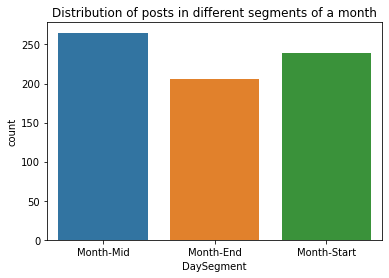

In [46]:
sns.countplot(data=data, x = "DaySegment")
plt.title("Distribution of posts in different segments of a month")

plt.show()

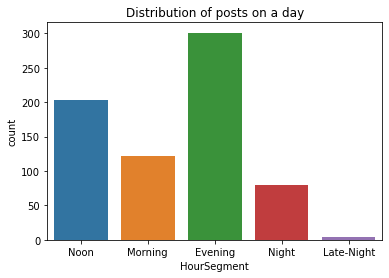

In [47]:
sns.countplot(data=data, x = "HourSegment")
plt.title("Distribution of posts on a day")

plt.show()

Insights:-
1. *Instagram appears to be the highly used social media platform.*
2. *Q1 and Q3 have comaparatively high number of posts.*
3. *Mid-month period produced more number of Social Media Posts.*
4. *Majority of posts are posted in evening hours while late-night hours produced almost negligible number of posts.*


#### Top 10 Hashtags and Sentiments and related plots

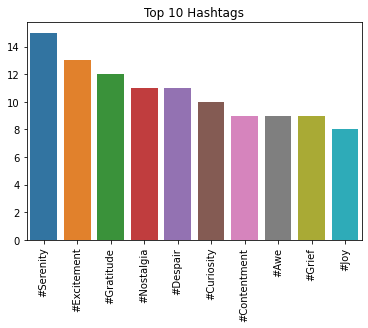

#Serenity       15
#Excitement     13
#Gratitude      12
#Nostalgia      11
#Despair        11
#Curiosity      10
#Contentment     9
#Awe             9
#Grief           9
#Joy             8
Name: Hashtags, dtype: int64

In [48]:
top_10_hashtags = data_hashtags["Hashtags"].value_counts()[:10]

sns.barplot(x = top_10_hashtags.index, y = top_10_hashtags.values)

plt.title("Top 10 Hashtags")
plt.xticks(rotation = 90)
plt.show()

top_10_hashtags

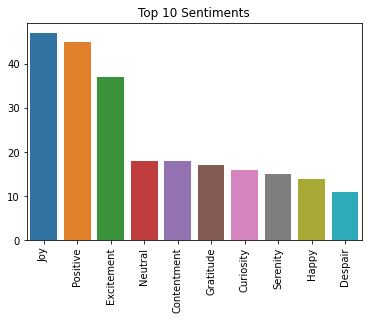

Joy            47
Positive       45
Excitement     37
Neutral        18
Contentment    18
Gratitude      17
Curiosity      16
Serenity       15
Happy          14
Despair        11
Name: Sentiment, dtype: int64

In [49]:
top_10_sentiments = data_sentiments["Sentiment"].value_counts()[:10]

sns.barplot(x = top_10_sentiments.index, y = top_10_sentiments.values)
plt.title("Top 10 Sentiments")
plt.xticks(rotation = 90)
plt.show()

top_10_sentiments

Insights:- As per frequency of posting-
1. **`#Serenity, #Excitement and #Gratitude`** are the top 3 hashtags used.
2. **`Joy, Positive and Excitement`** are the top 3 sentiments expressed.

### Bivariate Analysis

#### Bivariate Continous vs Continous Plots:-
- Checking correlation between Retweets and Likes

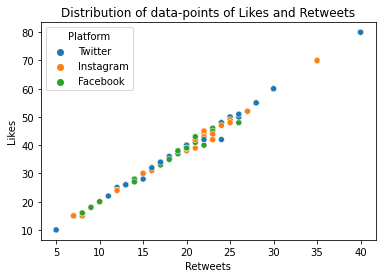

In [50]:
sns.scatterplot(data=data, x="Retweets", y="Likes", hue="Platform")

plt.title("Distribution of data-points of Likes and Retweets")
plt.show()

In [51]:
np.corrcoef(x=data["Retweets"], y=data["Likes"])[0, 0]

0.9999999999999999

Insights:-
1. *Likes and Retweets numbers are linearly correlated*

#### Bivariate Continous vs Categorical Plots

##### 1. Bar plot of Likes and Retweets for different Platforms

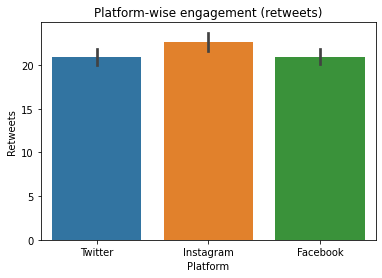

In [52]:
sns.barplot(data=data, x = "Platform", y = "Retweets")
plt.title("Platform-wise engagement (retweets)")

plt.show()

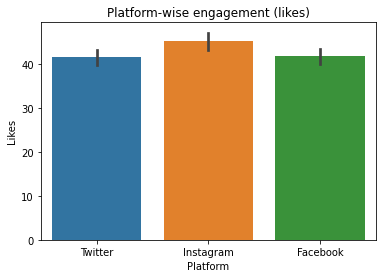

In [53]:
sns.barplot(data=data, x = "Platform", y = "Likes")
plt.title("Platform-wise engagement (likes)")

plt.show()

Insights:-
1. *Instagram produces comparatively more engagement whereas,*
2. *Twitter and Facebook have fairly same number of engagement.*

##### 2. Box plot, IQR and Outliers for different Platform

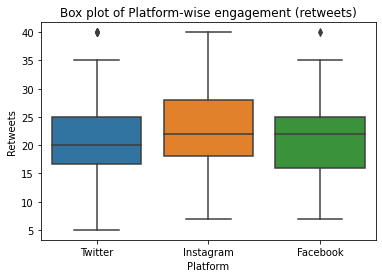

In [54]:
sns.boxplot(data=data, x = "Platform", y = "Retweets")
plt.title("Box plot of Platform-wise engagement (retweets)")

plt.show()


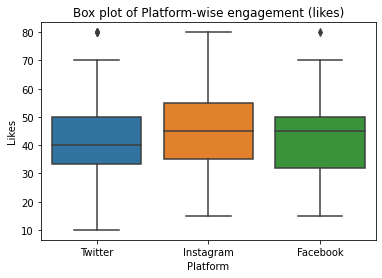

In [55]:
sns.boxplot(data=data, x = "Platform", y = "Likes")
plt.title("Box plot of Platform-wise engagement (likes)")

plt.show()

##### 3. Outliers Percentage

a. Outliers for Twitter

In [56]:
twitter_retweets = data[data["Platform"] == "Twitter"]["Retweets"]

p25 = np.percentile(twitter_retweets, 25)
p75 = np.percentile(twitter_retweets, 75)

iqr = p75 - p25

print(f"Range: {p25 - 1.5*iqr} to {p75 + 1.5*iqr}")

twitter_outliers = twitter_retweets[(twitter_retweets <= p25 - 1.5*iqr) | (twitter_retweets >= p75 + 1.5*iqr)].size

print(f"Count of Twitter outliers: {twitter_outliers}")

Range: 4.375 to 37.375
Count of Twitter outliers: 4


b. Instagram Outliers

In [57]:
ig_retweets = data[data["Platform"] == "Instagram"]["Retweets"]

p25 = np.percentile(ig_retweets, 25)
p75 = np.percentile(ig_retweets, 75)

iqr = p75 - p25

print(f"Range: {p25 - 1.5*iqr} to {p75 + 1.5*iqr}")

ig_outliers = ig_retweets[(ig_retweets <= p25 - 1.5*iqr) | (ig_retweets >= p75 + 1.5*iqr)].size

print(f"Count of Instagram outliers: {ig_outliers}")

Range: 3.0 to 43.0
Count of Instagram outliers: 0


c. Facebook Outliers

In [58]:
fb_retweets = data[data["Platform"] == "Facebook"]["Retweets"]

p25 = np.percentile(fb_retweets, 25)
p75 = np.percentile(fb_retweets, 75)

iqr = p75 - p25

print(f"Range: {p25 - 1.5*iqr} to {p75 + 1.5*iqr}")

fb_outliers = fb_retweets[(fb_retweets <= p25 - 1.5*iqr) | (fb_retweets >= p75 + 1.5*iqr)].size

print(f"Count of Facebook Outliers: {fb_outliers}")

Range: 2.5 to 38.5
Count of Facebook Outliers: 1


##### 4. Top 10 Hashtags, Sentiments and Country

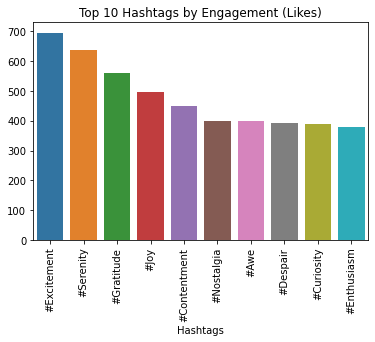

In [59]:
df = pd.merge(left=data[["id", "Likes"]], right=data_hashtags, on="id", how="inner")
top_10_hashtags = df.groupby("Hashtags")["Likes"].sum().sort_values(ascending=False)[:10]


sns.barplot(x = top_10_hashtags.index, y = top_10_hashtags.values)
plt.title("Top 10 Hashtags by Engagement (Likes)")
plt.xticks(rotation = 90)

plt.show()

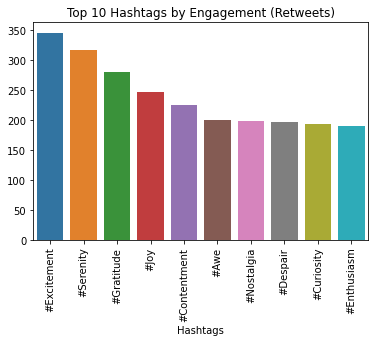

In [60]:
df = pd.merge(left=data[["id", "Retweets"]], right=data_hashtags, on="id", how="inner")
top_10_hashtags = df.groupby("Hashtags")["Retweets"].sum().sort_values(ascending=False)[:10]

sns.barplot(x = top_10_hashtags.index, y = top_10_hashtags.values)
plt.title("Top 10 Hashtags by Engagement (Retweets)")
plt.xticks(rotation = 90)

plt.show()

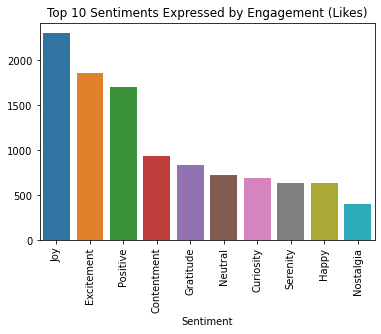

In [61]:
df = pd.merge(left=data[["id", "Likes"]], right=data_sentiments, on="id", how="inner")
top_10_sentiments = df.groupby("Sentiment")["Likes"].sum().sort_values(ascending=False)[:10]

sns.barplot(x = top_10_sentiments.index, y = top_10_sentiments.values)
plt.title("Top 10 Sentiments Expressed by Engagement (Likes)")
plt.xticks(rotation = 90)

plt.show()

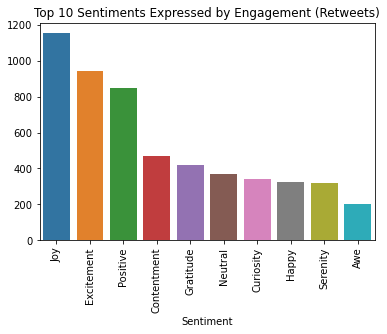

In [62]:
df = pd.merge(left=data[["id", "Retweets"]], right=data_sentiments, on="id", how="inner")
top_10_sentiments = df.groupby("Sentiment")["Retweets"].sum().sort_values(ascending=False)[:10]

sns.barplot(x = top_10_sentiments.index, y = top_10_sentiments.values)
plt.title("Top 10 Sentiments Expressed by Engagement (Retweets)")
plt.xticks(rotation = 90)

plt.show()

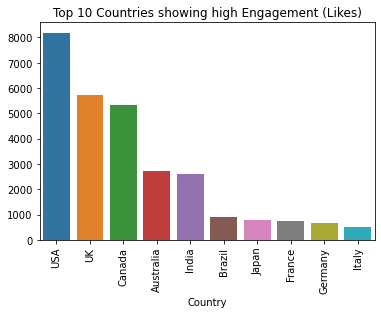

In [63]:
top_10_country = data.groupby("Country")["Likes"].sum().sort_values(ascending=False)[:10]

sns.barplot(x = top_10_country.index, y = top_10_country.values)
plt.title("Top 10 Countries showing high Engagement (Likes)")
plt.xticks(rotation = 90)

plt.show()

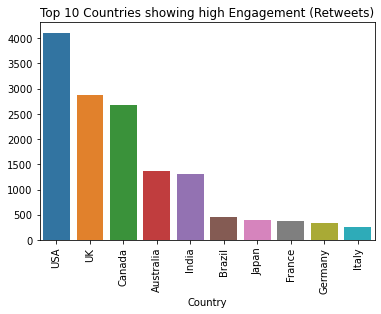

In [64]:
top_10_country = data.groupby("Country")["Retweets"].sum().sort_values(ascending=False)[:10]

sns.barplot(x = top_10_country.index, y = top_10_country.values)
plt.title("Top 10 Countries showing high Engagement (Retweets)")
plt.xticks(rotation = 90)

plt.show()

Insights:-
1. **`#Excitement, #Serenity and #Gratitude`** are the top 3 hashtags that produced highest engagement.
2. **`Joy, Excitement and Positive`** are the top 3 sentiments that attracts highest engagement.
3. **`USA, UK and Canada`** are the top 3 countries with highest engagement.

#### Time-Series (Trend) Analysis

a. Year wise growth in Engagement

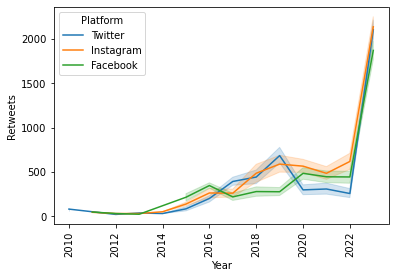

In [65]:
sns.lineplot(data=data, x="Year", y="Retweets", hue="Platform", estimator=np.sum)
plt.xticks(rotation = 90)
plt.show()

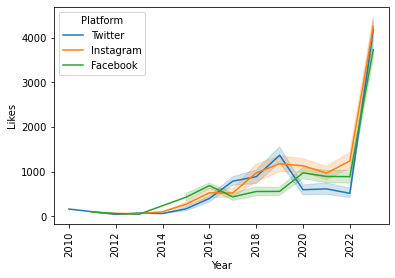

In [66]:
sns.lineplot(data=data, x="Year", y="Likes", hue="Platform", estimator=np.sum)
plt.xticks(rotation = 90)
plt.show()

b. Daily engagement

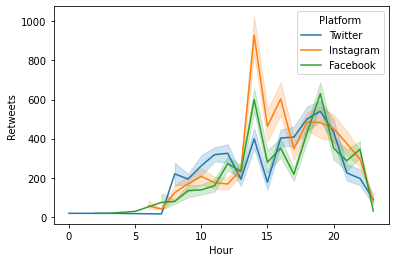

In [67]:
sns.lineplot(data=data, x="Hour", y="Retweets", hue="Platform", estimator=np.sum)
plt.show()

<AxesSubplot:xlabel='Hour', ylabel='Likes'>

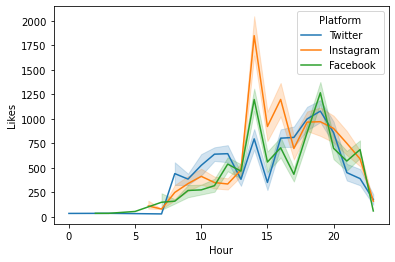

In [68]:
sns.lineplot(data=data, x="Hour", y="Likes", hue="Platform", estimator=np.sum)

Insights:-
1. There is a **sudden-rise in engagement in `2023`** for all 3 social media platforms.
2. **Evening hours gets the peak engagement for `Facebook and Twitter` platform, whereas `Instagram` gets peak engagement during Noon Hours.**
3. Overall **`Instagram`** gets highest engagement.
4. `Late Night` produce negligible engagement for all 3 platforms.

### Multivariate Plots

#### A. Create a heatmap to visualize engagement activity by hour and day. Investigate if there's a preferred time of day for posting for each sentiment.

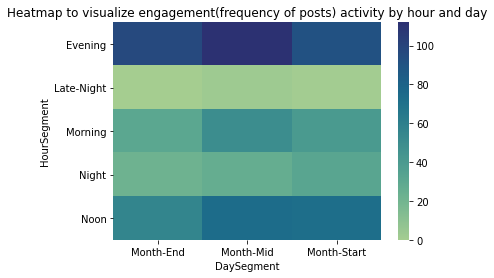

In [69]:
tmp = pd.crosstab(index=data["HourSegment"], columns=data["DaySegment"])
sns.heatmap(tmp, cmap="crest")
plt.title("Heatmap to visualize engagement(frequency of posts) activity by hour and day")
plt.show()

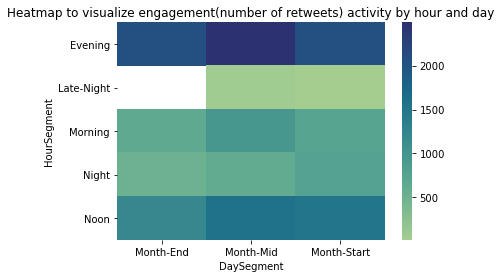

In [70]:
tmp = pd.crosstab(index=data["HourSegment"], columns=data["DaySegment"], aggfunc=np.sum, values=data["Retweets"])
sns.heatmap(tmp, cmap="crest")
plt.title("Heatmap to visualize engagement(number of retweets) activity by hour and day")
plt.show()

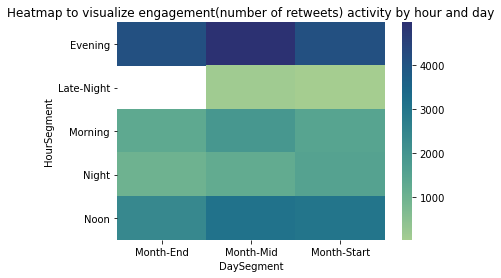

In [71]:
tmp = pd.crosstab(index=data["HourSegment"], columns=data["DaySegment"], aggfunc=np.sum, values=data["Likes"])
sns.heatmap(tmp, cmap="crest")
plt.title("Heatmap to visualize engagement(number of retweets) activity by hour and day")
plt.show()

Insights:-
1. *Above Heatmaps implies that engagement/usage is very high in Evening Hours and mid-month time period.*

#### B. Analyze the distribution of posts across different platforms and their associated sentiments.

In [72]:
df = pd.merge(left=data[["id", "Platform", "Likes", "Retweets"]], right=data_sentiments, on="id", how="inner")

twitter_data = df[df["Platform"] == "Twitter"]
twitter_data["Sentiment"].value_counts()

Positive        13
Excitement      13
Joy             10
Gratitude        7
Neutral          6
                ..
Sorrow           1
Intimidation     1
Grief            1
Anticipation     1
Culinary         1
Name: Sentiment, Length: 121, dtype: int64

In [73]:
ig_data = df[df["Platform"] == "Instagram"]
ig_data["Sentiment"].value_counts()

Positive       16
Joy            15
Excitement     13
Happy           6
Contentment     6
               ..
Jealousy        1
Coziness        1
Vibrancy        1
Connection      1
Romance         1
Name: Sentiment, Length: 122, dtype: int64

In [74]:
fb_data = df[df["Platform"] == "Facebook"]
fb_data["Sentiment"].value_counts()

Joy            22
Positive       16
Excitement     11
Curiosity       6
Contentment     6
               ..
Resilience      1
Festive         1
Envy            1
Calmness        1
Surprise        1
Name: Sentiment, Length: 102, dtype: int64

In [75]:
data_sentiments["Sentiment"].value_counts()

Joy            47
Positive       45
Excitement     37
Neutral        18
Contentment    18
               ..
Festive         1
Beauty          1
Positivity      1
Bittersweet     1
Storm           1
Name: Sentiment, Length: 202, dtype: int64

Note:- 
1. `'Joy', 'Positive' and 'Excitement'` are the top 3 expressed Sentiments and generates highest engagement.

In [76]:
top_3_sentiments = ['Joy', 'Positive', 'Excitement']

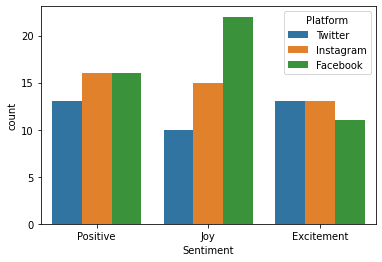

In [77]:
top_3_sentiments_data = df[df["Sentiment"].isin(top_3_sentiments)]
sns.countplot(data = top_3_sentiments_data, x = "Sentiment", hue="Platform")
plt.show()

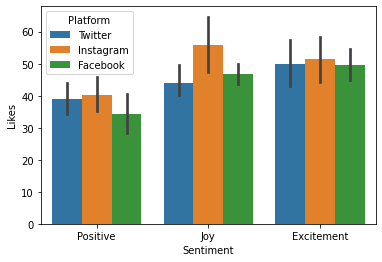

In [78]:
sns.barplot(data = top_3_sentiments_data, x = "Sentiment", y = "Likes", hue="Platform")
plt.show()

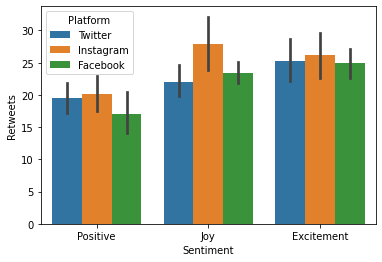

In [79]:
sns.barplot(data = top_3_sentiments_data, x = "Sentiment", y = "Retweets", hue="Platform")
plt.show()

Insights:-
1. `Instagram` engage more audience in posts related to top 3 Sentiments.
2. *Despite, there are more posts related to `Joy` sentiments on Facebook, but it can not engage more audience as Instagram beats facebook in terms of Engagement.*
3. `Twitter` have slightly less engagement in posts related to top 3 Sentiments.

#### C. Identify top users by engagement metrics and analyze their sentiment distribution.

In [80]:
top_5_user = data.groupby("User")["Likes"].sum().sort_values(ascending=False)[:5].index
top_5_user_data = data[data["User"].isin(top_5_user)]

In [81]:
df = pd.merge(left = top_5_user_data, right = data_sentiments, on="id", how="inner")

grouped_data = df.groupby("Sentiment")["Likes"].sum().sort_values(ascending=False)
grouped_data

Sentiment
Wonder        160
Harmony       140
Elation        80
Adventure      70
Culinary       70
Odyssey        70
Awe            55
Positive       45
Admiration     40
Immersion      40
Reverence      35
Name: Likes, dtype: uint8

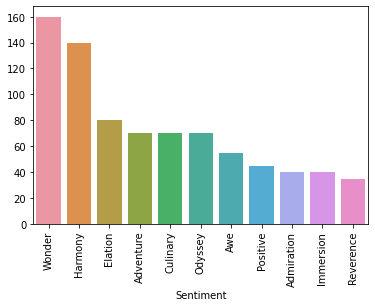

In [82]:
sns.barplot(x = grouped_data.index, y = grouped_data.values)
plt.xticks(rotation = 90)
plt.show()

Insights:-
1. Users with maximum engagements often expresses `'Wonder' and 'Harmony'` followed by `'Elation', 'Adventure', 'Culinary' and 'Odyssey'` as their sentiments.

### Test if there is a significant difference in engagement (likes, retweets) between different sentiments.

In [83]:
def print_test_result(p_value, alpha, Ho, Ha):
    if p_value < alpha:
        print("Reject Null Hypothesis")
        print(Ha)
    else:
        print("Failed to reject Null Hypothesis")
        print(Ho)


In [84]:
top_3_sentiments

['Joy', 'Positive', 'Excitement']

In [85]:
top_3_sentiments_data = pd.merge(left = data[["id", "Retweets", "Likes"]], right = data_sentiments[data_sentiments["Sentiment"].isin(top_3_sentiments)], on = "id", how = "inner")
top_3_sentiments_data.head()

,id,Retweets,Likes,Sentiment
0,1,15,30,Positive
1,3,20,40,Positive
2,4,8,15,Positive
3,6,25,50,Positive
4,7,10,20,Positive


#### Conducting appropriate tests on likes data.

In [86]:
positive_likes_data = top_3_sentiments_data[top_3_sentiments_data["Sentiment"] == "Positive"]["Likes"]
joy_likes_data = top_3_sentiments_data[top_3_sentiments_data["Sentiment"] == "Joy"]["Likes"]
excitement_likes_data = top_3_sentiments_data[top_3_sentiments_data["Sentiment"] == "Excitement"]["Likes"]


1. Checking Normality of distribution of likes for top 3 sentiments

In [87]:
Ho ="Data is Normally Distributed"
Ha = "Data is not Normally Distributed"

alpha = 0.05

In [88]:
# Normality test of positive_likes_data
stat, p_value = stats.shapiro(positive_likes_data)
print_test_result(p_value, alpha, Ho, Ha)

Reject Null Hypothesis
Data is not Normally Distributed


In [89]:
# Normality test of joy_likes_data
stat, p_value = stats.shapiro(joy_likes_data)
print_test_result(p_value, alpha, Ho, Ha)

Reject Null Hypothesis
Data is not Normally Distributed


In [90]:
# Normality test of excitement_likes_data
stat, p_value = stats.shapiro(excitement_likes_data)
print_test_result(p_value, alpha, Ho, Ha)

Failed to reject Null Hypothesis
Data is Normally Distributed


- Sentiments data is not normally distributed.
- So Perform Kruskal test to check whether distribution is same throughtout these sentiments or not.

2. Conducting Kruskal test on above 3 founded likes data with 5% significance level

In [91]:
Ho = "Average number of Likes is essentially same throughout different Sentiments"
Ha = "There is a significance difference in average number of Likes for different sentiments"

alpha = 0.05

In [92]:
f_stat, p_value = stats.kruskal(positive_likes_data, joy_likes_data, excitement_likes_data)

print_test_result(p_value, alpha, Ho, Ha)

Reject Null Hypothesis
There is a significance difference in average number of Likes for different sentiments


3. Conducting pair-wise t-test now.

3. a.) T-Test b/w `Positive vs Joy` Sentiments

In [93]:
Ho = "Average number of Likes is essentially same for posts expressing Positive and Joy as Sentiments"
Ha = "There is a significance difference in average number of Likes for different sentiments"

alpha = 0.05

t_stat, p_value = stats.ttest_ind(positive_likes_data, joy_likes_data)

print_test_result(p_value, alpha, Ho, Ha)

Reject Null Hypothesis
There is a significance difference in average number of Likes for different sentiments


3. b.) T-Test b/w `Positive vs Excitement` Sentiments

In [94]:
Ho = "Average number of Likes is essentially same for posts expressing Positive and Excitement as Sentiments"
Ha = "There is a significance difference in average number of Likes for different sentiments"

alpha = 0.05

t_stat, p_value = stats.ttest_ind(positive_likes_data, excitement_likes_data)

print_test_result(p_value, alpha, Ho, Ha)

Reject Null Hypothesis
There is a significance difference in average number of Likes for different sentiments


3. c.) T-Test b/w `Excitement vs Joy` Sentiments

In [95]:
Ho = "Average number of Likes is essentially same for posts expressing Excitement and Joy as Sentiments"
Ha = "There is a significance difference in average number of Likes for different sentiments"

alpha = 0.05

t_stat, p_value = stats.ttest_ind(excitement_likes_data, joy_likes_data)

print_test_result(p_value, alpha, Ho, Ha)

Failed to reject Null Hypothesis
Average number of Likes is essentially same for posts expressing Excitement and Joy as Sentiments


Overall average number number of likes differs between Sentiments.

#### Conducting test to check whether likes obtained are generally twice of retweets or not

In [96]:
likes = data["Likes"]
retweets = data["Retweets"]

Ho = "There is no significance difference in average number of likes and twice of retweets"
Ha = "There is a significance difference in average number of likes and twice of retweets"

alpha = 0.05

t_stat, p_value = stats.ttest_ind(likes, 2*retweets)

print_test_result(p_value, alpha, Ho, Ha)

Failed to reject Null Hypothesis
There is no significance difference in average number of likes and twice of retweets


### Identify the most popular hashtags used and their association with sentiment and engagement.

In [97]:
df = pd.merge(left=data_hashtags, right=data_sentiments, on="id", how="inner")
df = pd.merge(left=df, right=data[["id", "Likes", "Retweets"]], on="id", how="inner")

df.head()

,id,Hashtags,Sentiment,Likes,Retweets
0,1,#Nature,Positive,30,15
1,1,#Park,Positive,30,15
2,2,#Traffic,Negative,10,5
3,2,#Morning,Negative,10,5
4,3,#Fitness,Positive,40,20


In [98]:
df[["Hashtags", "Sentiment"]].value_counts()

Hashtags             Sentiment     
#Serenity            Serenity          15
#Excitement          Excitement        12
#Despair             Despair           11
#Nostalgia           Nostalgia         11
#Gratitude           Gratitude         11
                                       ..
#HappinessMilestone  Accomplishment     1
#HauntedPast         Regret             1
#Health              Negative           1
#HealthyLiving       Excitement         1
#Isolation           Loneliness         1
Length: 1101, dtype: int64

In [99]:
df.groupby(["Hashtags", "Sentiment"])[["Likes", "Retweets"]].sum().sort_values("Likes", ascending=False)[:20]

,,Likes,Retweets
Hashtags,Sentiment,,
#Excitement,Excitement,655.0,326.0
#Serenity,Serenity,636.0,317.0
#Gratitude,Gratitude,510.0,255.0
#Joy,Joy,495.0,247.0
#Contentment,Contentment,451.0,226.0
#Awe,Awe,400.0,201.0
#Nostalgia,Nostalgia,400.0,198.0
#Despair,Despair,392.0,197.0
#Curiosity,Curiosity,388.0,194.0


Insights:-
1. From above table it is evident that Same word is used for Hashtag and resembling Sentiment.
2. Top 3 Hashtags are - `#Excitement, #Serenity and #Gratitude`.